In [84]:
import os 
os.chdir('/local/crv/acanberk/folding-unfolding/src')

from cProfile import Profile
from configparser import Interpolation
from operator import truediv
from re import I
from tkinter import Image
# from tables import Filters
import torch.nn as nn
import torch
from scipy import ndimage as nd
import cv2
from typing import List
import random
from time import time
import ray
import numpy as np
from functools import lru_cache
from learning.utils import generate_positional_encoding
from learning.gui_utils import ExpertDemonstrationWindow
from learning.unet_parts import *
import imutils
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
import h5py 
from tqdm import tqdm

@lru_cache
def generate_coordinate_map(dim, rotation, scale):
    MAX_SCALE=5
    coordinate_dim = int(dim * (MAX_SCALE/scale))
    x, y = np.meshgrid(MAX_SCALE * np.linspace(-1 , 1, coordinate_dim), MAX_SCALE * np.linspace(-1 , 1, coordinate_dim), indexing="ij")
    x, y = x.reshape(coordinate_dim, coordinate_dim, 1), y.reshape(coordinate_dim, coordinate_dim, 1)
    xy = np.concatenate((x, y), axis=2)
    xy = imutils.rotate(xy, rotation)
    center = coordinate_dim/2

    new_dim = int(center + center * scale/MAX_SCALE) - int(center - center * scale/MAX_SCALE)
    offset = 0
    if int(new_dim) != dim:
        offset = int(dim - new_dim)

    xy = xy[int(center - center * scale/MAX_SCALE) : int(center + center * scale/MAX_SCALE) + offset, \
         int(center - center * scale/MAX_SCALE):int(center + center * scale/MAX_SCALE) + offset, :]
    return xy / MAX_SCALE
    


In [90]:


def new_transform(img, rotation: float, scale: float, dim: int, bilinear: bool):

     #to adjust code
    rotation *= -1 

    # img = transforms.functional.resize(img, (512, 512))
    # img = transforms.functional.resize(img, (512, 512))
    # img = transforms.functional.resize(img, (512, 512))
    # img = transforms.functional.resize(img, (512, 512))
    interpolation = transforms.InterpolationMode.BILINEAR if bilinear else transforms.InterpolationMode.NEAREST

    img = transforms.functional.rotate(img, rotation, interpolation=interpolation)
    img = transforms.functional.resize(img, (dim, dim))

    if scale < 1:
        img = transforms.functional.center_crop(img, (int(dim * scale), int(dim * scale)))
        img = transforms.functional.resize(img, (dim, dim))
    else:
        zeros = torch.zeros((img.shape[0], dim, dim), device=img.device)
        img = transforms.functional.resize(img, (int(dim/scale), int(dim/scale)))

        end = zeros.shape[-1]//2 + int(img.shape[-1])//2
        begin = zeros.shape[-1]//2 - int(img.shape[-1])//2
        if end - begin < img.shape[-1]:
            end += 1        
        
        zeros[..., begin:end, begin:end] = img
        img = zeros

    coordinate_map = torch.tensor(generate_coordinate_map(dim, rotation, scale))
    coordinate_map = coordinate_map.permute(2, 0, 1)
    img = torch.cat([img, coordinate_map], axis=0)

    return img


def old_transform(img, rotation: float, scale: float, dim: int):
    img = img.to('cuda:0')
    inter_dim = dim * 2
    img = transforms.functional.resize(img, (inter_dim, inter_dim))
    img = transforms.functional.rotate(img, rotation)
    img = transforms.functional.center_crop(img, (int(inter_dim * scale), int(inter_dim * scale)))
    img = transforms.functional.resize(img, (dim, dim))
    return img

def crop_center(img, crop):
    startx = img.shape[1]//2-(crop//2)
    starty = img.shape[0]//2-(crop//2)
    return img[starty:starty+crop, startx:startx+crop, ...]

def old_transform(img, rotation: float, scale: float, dim: int):

    #img shape (c, 720, 720)
    if len(img.shape) == 3 and (img.shape[-1] == img.shape[-2]):
        img = img.permute(2, 1, 0)

    img = img.numpy()

    # print("Transform image shape", img.shape)
    #scale
    if scale < 1:
        #concatenate with img with coords         
        new_dim = int(scale*img.shape[0])
        # print("New dim is", new_dim)
        img = crop_center(img, new_dim)
        img = cv2.resize(img, dsize=(dim, dim),
                    interpolation=cv2.INTER_NEAREST)

    elif scale > 1:
        new_dim = int((1/scale)*dim)
        pad = (dim - new_dim)//2
        zeros = np.zeros((dim, dim, img.shape[-1]))
        zeros[pad:pad+new_dim, pad:pad+new_dim, :] = cv2.resize(img, dsize=(new_dim, new_dim), interpolation=cv2.INTER_NEAREST)
        img = zeros
    else:
        img = cv2.resize(img, dsize=(dim, dim), interpolation=cv2.INTER_NEAREST)

    img = imutils.rotate(img, rotation)

    coordinate_map = generate_coordinate_map(dim, rotation, scale)
    img = np.concatenate([img, coordinate_map], axis=-1)

    # x_coord_map = fling_direction_map(dim, rotation, scale).reshape(dim, dim, 1)
    # y_coord_map = fling_direction_map(dim, rotation+90, scale).reshape(dim, dim, 1)

    # img = np.concatenate([img, x_coord_map], axis=-1)
    # img = np.concatenate([img, y_coord_map], axis=-1)

    #plot image and coordinate map in subplots
    if len(img.shape) == 3:
        img = img.swapaxes(-1, 0)
    return torch.tensor(img)


def ancient_transform(img, rotation: float, scale: float, dim: int):
    if len(img.shape) == 3 and (img.shape[-1] == img.shape[-2]):
        img = img.permute(2, 1, 0)
    # rotate
    img = nd.rotate(input=img,
                    angle=rotation,
                    reshape=False,
                    mode='nearest')
    # scale
    new_dim = int(scale*img.shape[0])
    if scale < 1:
        img = crop_center(img, new_dim)
    elif scale > 1:
        img = pad(img, new_dim)
    # resize
    img = cv2.resize(img, dsize=(dim, dim),
                     interpolation=cv2.INTER_NEAREST)
    if len(img.shape) == 3:
        img = img.swapaxes(-1, 0)
    return torch.tensor(img)


In [91]:

dataset_path = '/local/crv/acanberk/folding-unfolding/src/experiments/1807-test/replay_buffer.hdf5'

        

23it [00:00, 91.50it/s]


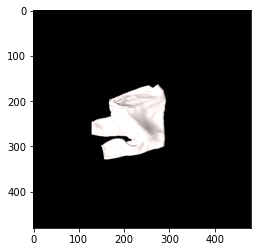

In [92]:

with h5py.File(dataset_path, "r") as dataset:
    for i, k in tqdm(zip(range(np.random.randint(0, 100)), dataset)):
        group = dataset[k]
        observation = np.array(group['pretransform_observations'])
        # print(observation.shape)
        plt.imshow(observation[:3, :, :].transpose(1, 2, 0))

WARNING - 2022-07-19 19:14:06,776 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


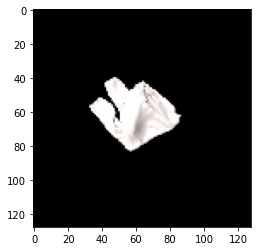

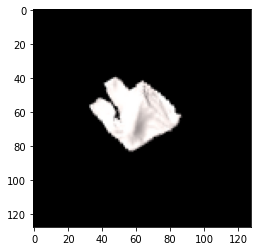

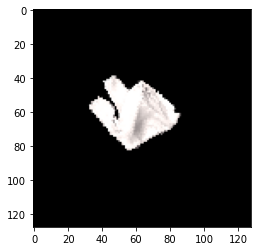

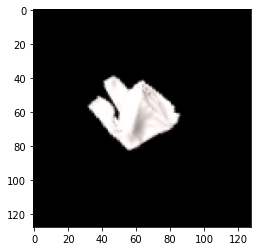

In [93]:

def pad(img, size):
    n = (size-img.shape[0])//2
    return cv2.copyMakeBorder(img, n, n, n, n, cv2.BORDER_REPLICATE)

scale = 1
rotation = 60
obs = torch.tensor(observation)
ancient = ancient_transform(obs.clone(), rotation, scale, 128)
old = old_transform(obs.clone(), rotation, scale, 128)

new = new_transform(obs.clone(), rotation, scale, 128, bilinear=False)
new_bilinear = new_transform(obs.clone(), rotation, scale, 128, bilinear=True)


# print(old.shape)
# print(old[:3].shape)
plt.imshow(ancient[:3, :, :].permute(1, 2, 0))
plt.show()
plt.imshow(old[:3].permute(1, 2, 0))
plt.show()
plt.imshow(new[:3].cpu().permute(1, 2, 0))
plt.show()
plt.imshow(new_bilinear[:3].cpu().permute(1, 2, 0))
plt.show()


In [94]:
old.shape


torch.Size([6, 128, 128])

In [98]:
import time

start = time.time()
for _ in range(200):
    new = new_transform(obs.clone(), rotation, scale, 128, bilinear=False)
end = time.time()
print(end-start)

start = time.time()
for _ in range(200):
    new_bilinear = new_transform(obs.clone(), rotation, scale, 128, bilinear=True)
end = time.time()
print(end-start)


0.22468233108520508
0.2488102912902832
